In [1]:
import tensorflow as tf
print(tf.__version__)
tf.config.experimental_run_functions_eagerly(True)

physical_device = tf.config.experimental.list_physical_devices("GPU")
if len(physical_device) > 0:
    tf.config.experimental.set_memory_growth(physical_device[0], True)

2.2.0


# The Keras functional API

 ## Coding tutorials
 #### [1. Multiple inputs and outputs](#coding_tutorial_1)
 #### [2. Tensors and Variables](#coding_tutorial_2)
 #### [3. Accessing model layers](#coding_tutorial_3)
 #### [4. Freezing layers](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Multiple inputs and outputs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the acute inflammations dataset

The `acute inflammations` was created by a medical expert as a data set to test the expert system, which will perform the presumptive diagnosis of two diseases of the urinary system. You can find out more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Acute+Inflammations).

Attribute information:

Inputs:
- Temperature of patient : 35C-42C
- Occurrence of nausea : yes/no
- Lumbar pain : yes/no
- Urine pushing (continuous need for urination) : yes/no
- Micturition pains : yes/no
- Burning of urethra, itch, swelling of urethra outlet : yes/no

Outputs:
- decision 1: Inflammation of urinary bladder : yes/no
- decision 2: Nephritis of renal pelvis origin : yes/no

#### Import the data

The dataset required for this tutorial can be downloaded from the following link:

https://drive.google.com/open?id=1CDPQSqpI7OjNIgOERWaI-BlQMI6vjzb9

You should store this file in Drive for use in this Colab notebook.

#### Load the data

In [3]:
# Load the dataset

from sklearn.model_selection import train_test_split

pd_dat = pd.read_csv('diagnosis.csv')
dataset = pd_dat.values

In [4]:
# Build train and test data splits

X_train, X_test, Y_train, Y_test = train_test_split(dataset[:,:6], dataset[:,6:], test_size=0.33)

In [5]:
# Assign training and testing inputs/outputs

temp_train, nocc_train, lumbp_train, up_train, mict_train, bis_train = np.transpose(X_train)
temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test = np.transpose(X_test)

inflam_train, nephr_train = Y_train[:, 0], Y_train[:, 1]
inflam_test, nephr_test = Y_test[:, 0], Y_test[:, 1]

#### Build the model

In [6]:
# Build the input layers
from tensorflow.keras import Input, layers
shape_inputs = (1, )
temperature = Input(shape=shape_inputs, name='temp')
nausea_occurence = Input(shape=shape_inputs, name='nausea')
lumbar_pain = Input(shape=shape_inputs, name='lumbar')
urine_pushing = Input(shape=shape_inputs, name='up')
micturition_pains = Input(shape=shape_inputs, name='mict')
bis = Input(shape=shape_inputs, name='bis')

In [7]:
# Create a list of all the inputs

list_inputs = [temperature, nausea_occurence, lumbar_pain, urine_pushing, 
               micturition_pains, bis]

In [8]:
# Merge all input features into a single large vector
x = layers.concatenate(list_inputs)


In [9]:
# Use a logistic regression classifier for disease prediction
inflammation_pred = layers.Dense(1, activation='sigmoid', name='inflam')(x)
nephritis_pred = layers.Dense(1, activation='sigmoid', name='nephr')(x)


In [10]:
# Create a list of all the outputs

list_outputs = [inflammation_pred, nephritis_pred]

In [11]:
# Create the model object
model = tf.keras.Model(inputs=list_inputs, outputs= list_outputs)


#### Plot the model

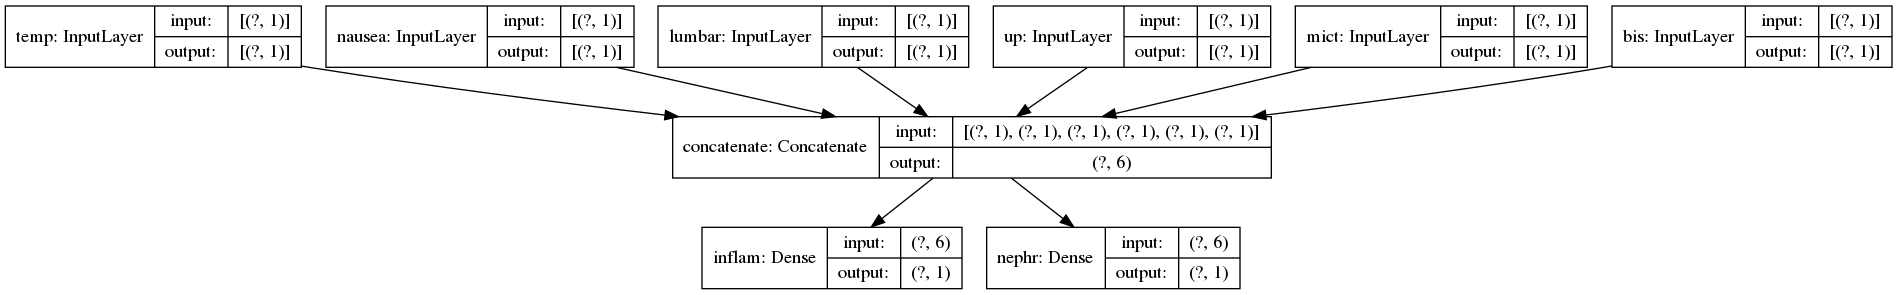

In [12]:
# Display the multiple input/output model
tf.keras.utils.plot_model(model, 'multi_input_output_model.png', show_shapes=True)


#### Compile the model

In [30]:
# Compile the model

model.compile(optimizer=tf.keras.optimizers.RMSprop(1e-3),
              loss={'inflam': 'binary_crossentropy',
                    'nephr': 'binary_crossentropy'},
              metrics={'inflam': 'accuracy',
                       'nephr' : 'accuracy'},
              loss_weights=[1.0, 1.2])

#### Fit the model 

In [31]:
# Define training inputs and outputs

inputs_train = {'temp': temp_train, 'nausea': nocc_train, 'lumbar': lumbp_train,
                'up': up_train, 'mict': mict_train, 'bis': bis_train}

outputs_train = {'inflam': inflam_train, 'nephr': nephr_train}

In [32]:
# Train the model
history = model.fit(inputs_train, outputs_train, epochs=1000,
          batch_size=128, verbose=False)

#### Plot the learning curves

In [33]:
import pandas as pd
pd.DataFrame(history.history).head()

loss  inflam_loss  nephr_loss  inflam_accuracy  nephr_accuracy
0  11.607833     0.107903    9.583275              1.0           0.375
1  11.608103     0.108173    9.583275              1.0           0.375
2  11.607492     0.107562    9.583275              1.0           0.375
3  11.607357     0.107427    9.583275              1.0           0.375
4  11.607251     0.107321    9.583275              1.0           0.375

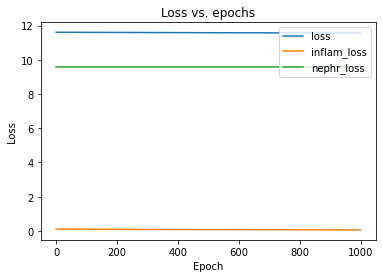

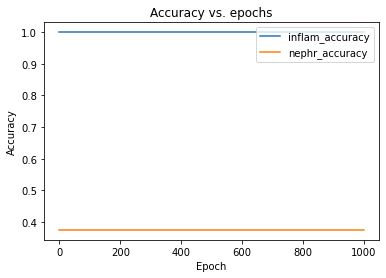

In [34]:
# Plot the training accuracy

acc_keys = [k for k in history.history.keys() if k in ('inflam_accuracy', 'nephr_accuracy')] 
loss_keys = [k for k in history.history.keys() if not k in acc_keys]

for k, v in history.history.items():
    if k in acc_keys:
        plt.figure(1)
        plt.plot(v)
    else:
        plt.figure(2)
        plt.plot(v)

plt.figure(1)
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(acc_keys, loc='upper right')

plt.figure(2)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loss_keys, loc='upper right')

plt.show()

In [35]:
# Evaluate the model

model.evaluate([temp_test, nocc_test, lumbp_test, up_test, mict_test, bis_test],
               [inflam_test, nephr_test], verbose=2)

2/2 - 0s - loss: 9.2600 - inflam_loss: 0.0601 - nephr_loss: 7.6666 - inflam_accuracy: 1.0000 - nephr_accuracy: 0.5000


[9.260043144226074, 0.0600997619330883, 7.666619777679443, 1.0, 0.5]

***
<a id="coding_tutorial_2"></a>
## Tensors and Variables

In [3]:
import numpy as np

#### Create Variable objects

In [4]:
# Create Variable objects of different type with tf.Variable

strings = tf.Variable(["Hello world!"], tf.string)
floats  = tf.Variable([3.14159, 2.71828], tf.float64)
ints = tf.Variable([1, 2, 3], tf.int32)
complexs = tf.Variable([25.9 - 7.39j, 1.23 - 4.91j], tf.complex128)

In [5]:
# Initialise a Variable value
tf.Variable(tf.constant(4.2, shape=(3,3)))

<tf.Variable 'Variable:0' shape=(3, 3) dtype=float32, numpy=
array([[4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2],
       [4.2, 4.2, 4.2]], dtype=float32)>

#### Use and modify Variable values

In [6]:
# Use the value of a Variable

v = tf.Variable(0.0)
w = v + 1  # w is a tf.Tensor which is computed based on the value of v.

print(type(w))

<class 'tensorflow.python.framework.ops.EagerTensor'>


In [10]:
# Increment the value of a Variable
v.assign_add(1)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=4.0>


In [11]:
# Decrement the value of a Variable
v.assign_sub(1)
print(v)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=3.0>


#### Create Tensor objects

Create a constant tensor and print its type as well as its shape:

In [12]:
# Create a constant Tensor

x = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(x)
print("dtype:", x.dtype)
print("shape:", x.shape)

tf.Tensor(
[[1 2 3]
 [4 5 6]
 [7 8 9]], shape=(3, 3), dtype=int32)
dtype: <dtype: 'int32'>
shape: (3, 3)


In [13]:
# Obtain the value as a numpy array

x.numpy()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]], dtype=int32)

In [14]:
# Create a Tensor of type float32
x = tf.constant([[1,2,3],[4,5,6],[7,8,9]], dtype=tf.float32)
print(x.dtype)

<dtype: 'float32'>


In [15]:
# Create coefficients

coeffs = np.arange(16)
coeffs

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [18]:
# Initialise shapes
shape1 = [8, 2]
shape2 = [4, 4]
shape3 = [2, 2, 2, 2]


In [19]:
# Create Tensors of different shape

a = tf.constant(coeffs, shape=shape1)
print("\n a:\n ", a)

b = tf.constant(coeffs, shape=shape2)
print("\n b:\n ", b)

c = tf.constant(coeffs, shape=shape3)
print("\n c:\n ", c)


 a:
  tf.Tensor(
[[ 0  1]
 [ 2  3]
 [ 4  5]
 [ 6  7]
 [ 8  9]
 [10 11]
 [12 13]
 [14 15]], shape=(8, 2), dtype=int64)

 b:
  tf.Tensor(
[[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]], shape=(4, 4), dtype=int64)

 c:
  tf.Tensor(
[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]], shape=(2, 2, 2, 2), dtype=int64)


#### Useful Tensor operations

In [25]:
# Create a constant Tensor

t = tf.constant(np.arange(80), shape=[5,2,8])

In [26]:
# Get the rank of a Tensor
rank = tf.rank(t)


In [27]:
# Display the rank

print("rank: ", rank)

rank:  tf.Tensor(3, shape=(), dtype=int32)


In [28]:
# Reshape a Tensor

t2 = tf.reshape(t, [8, 10])

In [29]:
# Display the new shape

print("t2.shape: ", t2.shape)

t2.shape:  (8, 10)


In [30]:
# Create ones, zeros, identity and constant Tensors
ones = tf.ones(shape=(2, 3))
zeros = tf.zeros(shape=(2, 4))
eye = tf.eye(3)
tensor7 = tf.constant(7.0, shape=(2, 2))


In [31]:
# Display the created tensors

print("\n Ones:\n ", ones)
print("\n Zeros:\n ", zeros)
print("\n Identity:\n ", eye)
print("\n Tensor filled with 7: ", tensor7)


 Ones:
  tf.Tensor(
[[1. 1. 1.]
 [1. 1. 1.]], shape=(2, 3), dtype=float32)

 Zeros:
  tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(2, 4), dtype=float32)

 Identity:
  tf.Tensor(
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]], shape=(3, 3), dtype=float32)

 Tensor filled with 7:  tf.Tensor(
[[7. 7.]
 [7. 7.]], shape=(2, 2), dtype=float32)


In [32]:
# Create a ones Tensor and a zeros Tensor

t1 = tf.ones(shape=(2, 2))
t2 = tf.zeros(shape=(2, 2))

In [33]:
# Concatentate two Tensors
concat0 = tf.concat([t1, t2], 0)
concat1 = tf.concat([t1, t2], 1)

In [34]:
# Display the concatenated tensors

print(concat0)
print(concat1)

tf.Tensor(
[[1. 1.]
 [1. 1.]
 [0. 0.]
 [0. 0.]], shape=(4, 2), dtype=float32)
tf.Tensor(
[[1. 1. 0. 0.]
 [1. 1. 0. 0.]], shape=(2, 4), dtype=float32)


In [35]:
# Create a constant Tensor

t = tf.constant(np.arange(24), shape=(3, 2, 4))
print("\n t shape: ", t.shape)


 t shape:  (3, 2, 4)


In [39]:
# Expanding the rank of Tensors

t1 = tf.expand_dims(t, 0)
t2 = tf.expand_dims(t, 1)
t3 = tf.expand_dims(t, 2)
t4 = tf.expand_dims(t, 3)

In [40]:
# Display the shapes after tf.expand_dims

print("\n After expanding dims:\n t1 shape: ", t1.shape, "\n t2 shape: ", t2.shape, "\n t3 shape: ", t3.shape, "\n t4 shape: ", t4.shape)


 After expanding dims:
 t1 shape:  (1, 3, 2, 4) 
 t2 shape:  (3, 1, 2, 4) 
 t3 shape:  (3, 2, 1, 4) 
 t4 shape:  (3, 2, 4, 1)


In [41]:
# Squeezing redundant dimensions

t1 = tf.squeeze(t1, 0)
t2 = tf.squeeze(t2, 1)
t3 = tf.squeeze(t3, 2)

In [42]:
# Display the shapes after tf.squeeze

print("\n After squeezing:\n t1 shape: ", t1.shape, "\n t2 shape: ", t2.shape, "\n t3 shape: ", t3.shape)


 After squeezing:
 t1 shape:  (3, 2, 4) 
 t2 shape:  (3, 2, 4) 
 t3 shape:  (3, 2, 4)


In [43]:
# Slicing a Tensor

x = tf.constant([1, 2, 3, 4, 5, 6, 7])

print(x[1:4])

tf.Tensor([2 3 4], shape=(3,), dtype=int32)


#### Doing maths with Tensors

In [44]:
# Create two constant Tensors

c = tf.constant([[1.0, 2.0], [3.0, 4.0]])
d = tf.constant([[1.0, 1.0], [0.0, 1.0]])

In [45]:
# Matrix multiplication

matmul_cd = tf.matmul(c, d)

In [46]:
# Display the result

print("\n tf.matmul(c,d):\n", matmul_cd)


 tf.matmul(c,d):
 tf.Tensor(
[[1. 3.]
 [3. 7.]], shape=(2, 2), dtype=float32)


In [48]:
# Elementwise operations
c_times_d = c*d
c_plus_d = c+d
c_minus_d = c-d
c_div_c = c/c


In [49]:
# Display the results

print("\n c*d:\n", c_times_d)
print("\n c+d:\n", c_plus_d)
print("\n c-d:\n", c_minus_d)
print("\n c/c:\n", c_div_c)


 c*d:
 tf.Tensor(
[[1. 2.]
 [0. 4.]], shape=(2, 2), dtype=float32)

 c+d:
 tf.Tensor(
[[2. 3.]
 [3. 5.]], shape=(2, 2), dtype=float32)

 c-d:
 tf.Tensor(
[[0. 1.]
 [3. 3.]], shape=(2, 2), dtype=float32)

 c/c:
 tf.Tensor(
[[1. 1.]
 [1. 1.]], shape=(2, 2), dtype=float32)


In [50]:
# Create Tensors

a = tf.constant([[2, 3], [3, 3]])
b = tf.constant([[8, 7], [2, 3]])
x = tf.constant([[-6.89 + 1.78j], [-2.54 + 2.15j]])

In [51]:
# Absolute value of a Tensor

absx = tf.abs(x)

In [54]:
# Power of a Tensor
powab = tf.pow(a, a)


In [55]:
# Display the results

print("\n ", absx)
print("\n ", powab)


  tf.Tensor(
[[7.11621388]
 [3.32777704]], shape=(2, 1), dtype=float64)

  tf.Tensor(
[[ 4 27]
 [27 27]], shape=(2, 2), dtype=int32)


#### Randomly sampled constant tensors

In [56]:
# Create a Tensor with samples from a Normal distribution

tn = tf.random.normal(shape=(2, 2), mean=0, stddev=1.)

In [57]:
# Create a Tensor with samples from a Uniform distribution

tu = tf.random.uniform(shape=(2, 1), minval=0, maxval=10, dtype='int32')

In [58]:
# Create a Tensor with samples from a Poisson distribution
tp = tf.random.poisson(shape=(2, 2), lam=5)


In [59]:
# More maths operations

d = tf.square(tn)
e = tf.exp(d)
f = tf.cos(c)

***
<a id="coding_tutorial_3"></a>
## Accessing model layers

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Load the pre-trained model

In this section, we aim to demonstrate accessing layer attributes within a model.

Let's get started by loading the `VGG19` pre-trained model from the `keras.applications` library, which is a very deep network trained on more than a million images from the ImageNet database. The network is trained to classify images into 1000 object categories.

In [6]:
# Load the VGG19 model
from tensorflow.keras.applications import VGG19

vgg_model = VGG19(weights='imagenet')

In [7]:
# Get the inputs, layers and display the summary

vgg_input = vgg_model.input
vgg_layers = vgg_model.layers
vgg_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#### Build a model to access the layer outputs

In [8]:
from tensorflow.keras.models import Model

In [9]:
# Build a model that returns the layer outputs

layers_outputs = [layer.output for layer in vgg_layers]
features = Model(inputs=vgg_input, outputs=layers_outputs)

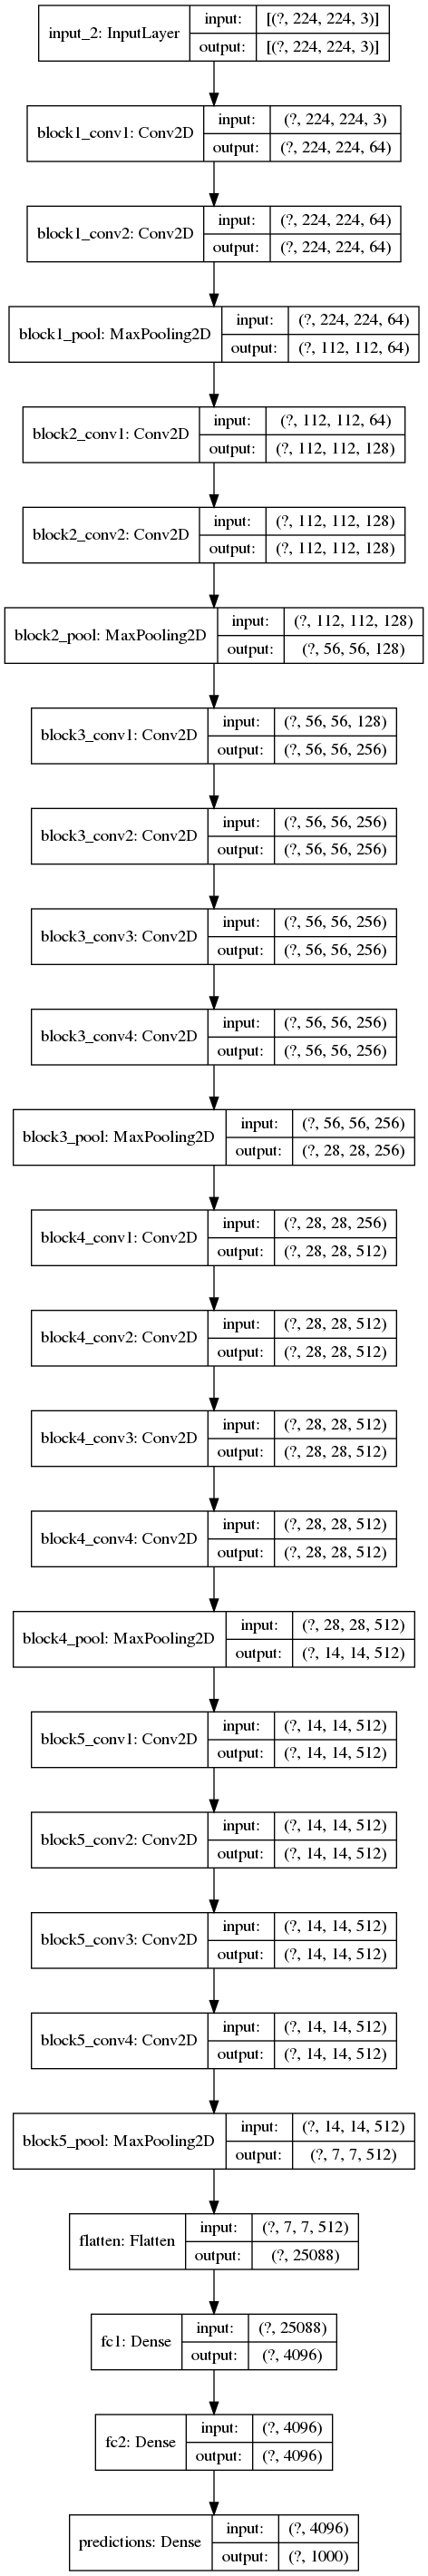

In [10]:
# Plot the model
tf.keras.utils.plot_model(features, 'vgg19_model.png', show_shapes=True)


In [11]:
# Test the model on a random input

img = np.random.random((1, 224, 224, 3)).astype('float32')
extracted_features = features(img)

#### Load the 'cool cat' picture

In Zambia’s South Luangwa National Park, a photographer had been watching a pride of lions while they slept off a feast from a buffalo kill. When this female walked away, he anticipated that she might be going for a drink and so he positioned his vehicle on the opposite side of the waterhole. The `cool cat` picture is one of the highly commended 2018 Image from Wildlife Photographer of the Year.

#### Import the picture

The dataset required for this tutorial can be downloaded from the following link:

https://drive.google.com/open?id=1myXpP8QFvhATqg0bPYhCpVS48_OgAC0L

You should store this file in Drive for use in this Colab notebook.

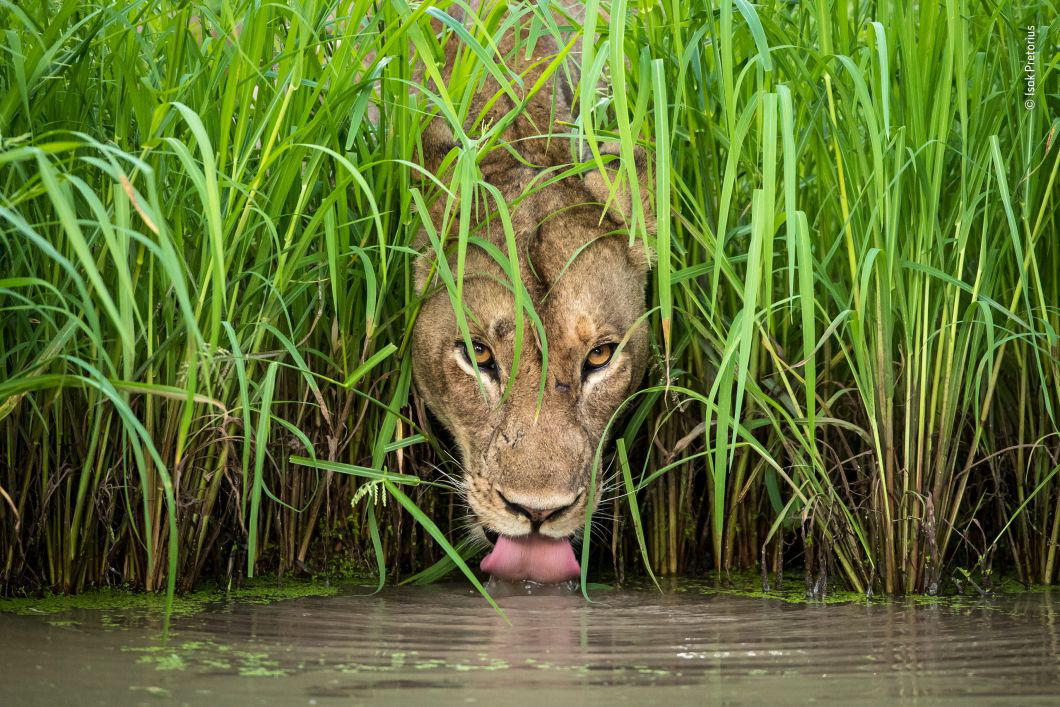

In [12]:
# Display the original image

import IPython.display as display
from PIL import Image

display.display(Image.open('cool_cat.jpg'))

#### Visualise network features from the input image

In [13]:
# Preprocess the image

from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image

img_path = 'cool_cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

In [14]:
# Extract the features

extracted_features = features(x)

f1.shape :  (1, 224, 224, 3)


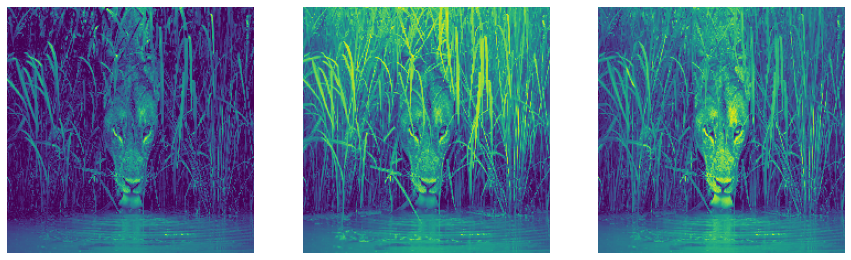

In [15]:
# Visualise the input channels
f1 = extracted_features[0]
print('f1.shape : ', f1.shape)

imgs = f1[0, :, :]
plt.figure(figsize=(15, 15))
for i in range(3):
    ax = plt.subplot(1, 3, i+1)
    plt.imshow(imgs[:, :, i])
    plt.axis('off')
    
plt.subplots_adjust()


f1.shape :  (1, 224, 224, 64)


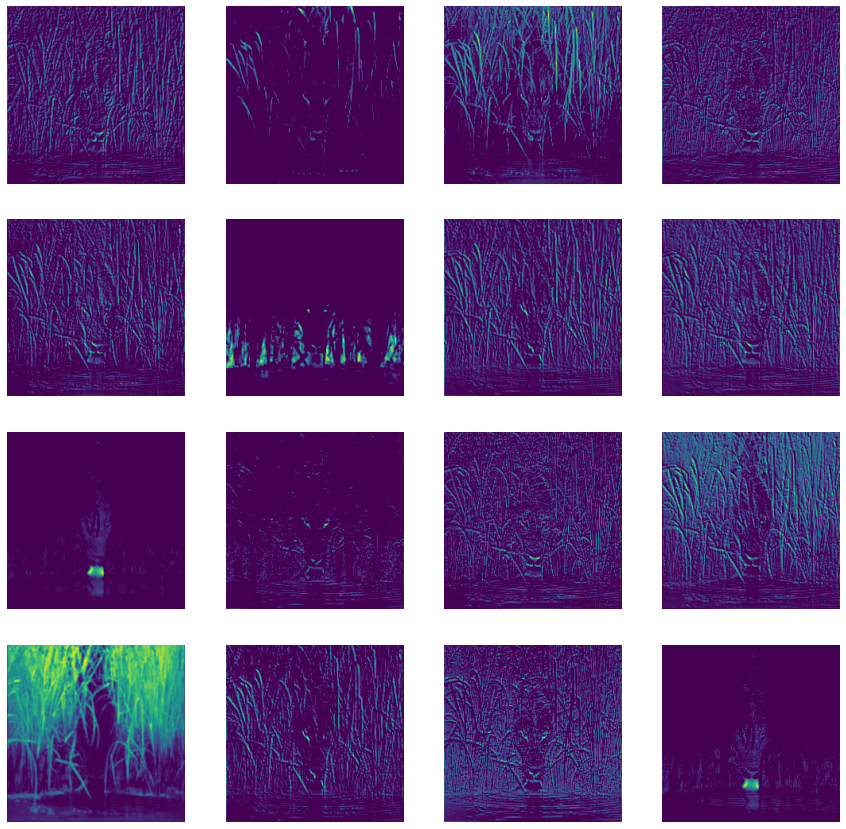

In [16]:
# Visualise some features in the first hidden layer
f2 = extracted_features[1]
print('f1.shape : ', f2.shape)

imgs = f2[0, :, :]
plt.figure(figsize=(15, 15))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(imgs[:, :, i])
    plt.axis('off')
    
plt.subplots_adjust()


In [17]:
# Build a model to extract features by layer name
extracted_features_block1_pool = Model(inputs=features.input, 
                                      outputs=features.get_layer('block1_pool').output)

block1_pool_features = extracted_features_block1_pool.predict(x)


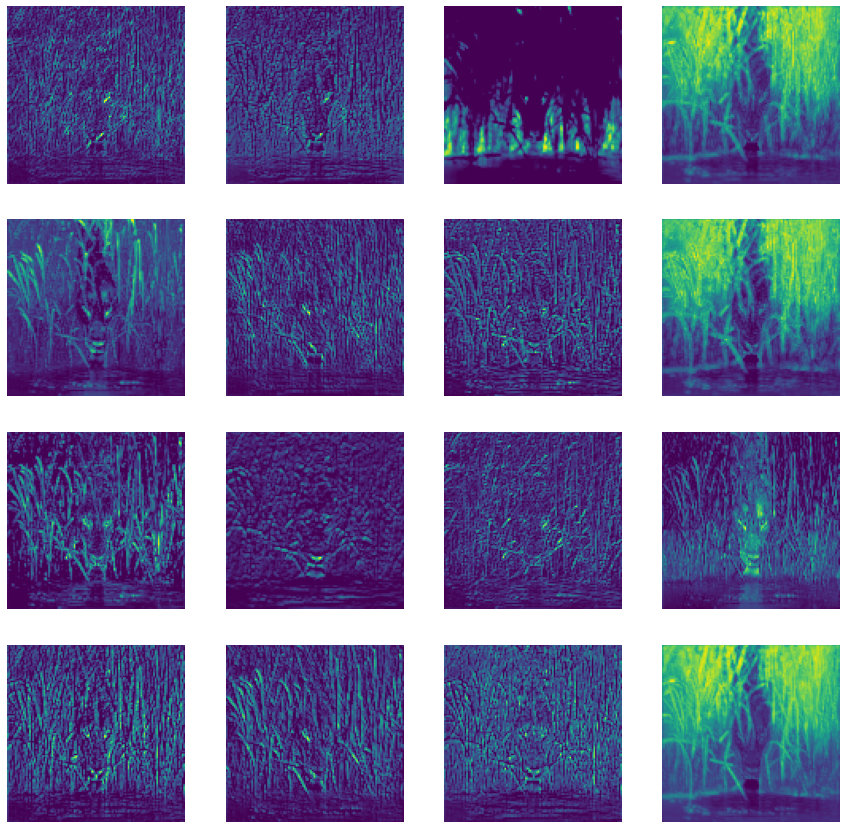

In [18]:
# Visualise some features from the extracted layer output

imgs = block1_pool_features[0, :, :]
plt.figure(figsize=(15, 15))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(imgs[:, :, i])
    plt.axis('off')
    
plt.subplots_adjust()


In [19]:
# Extract features from a layer deeper in the network
extracted_features_block5_conv4 = Model(inputs=features.input, 
                                      outputs=features.get_layer('block5_conv4').output)

block5_conv4_features = extracted_features_block5_conv4.predict(x)



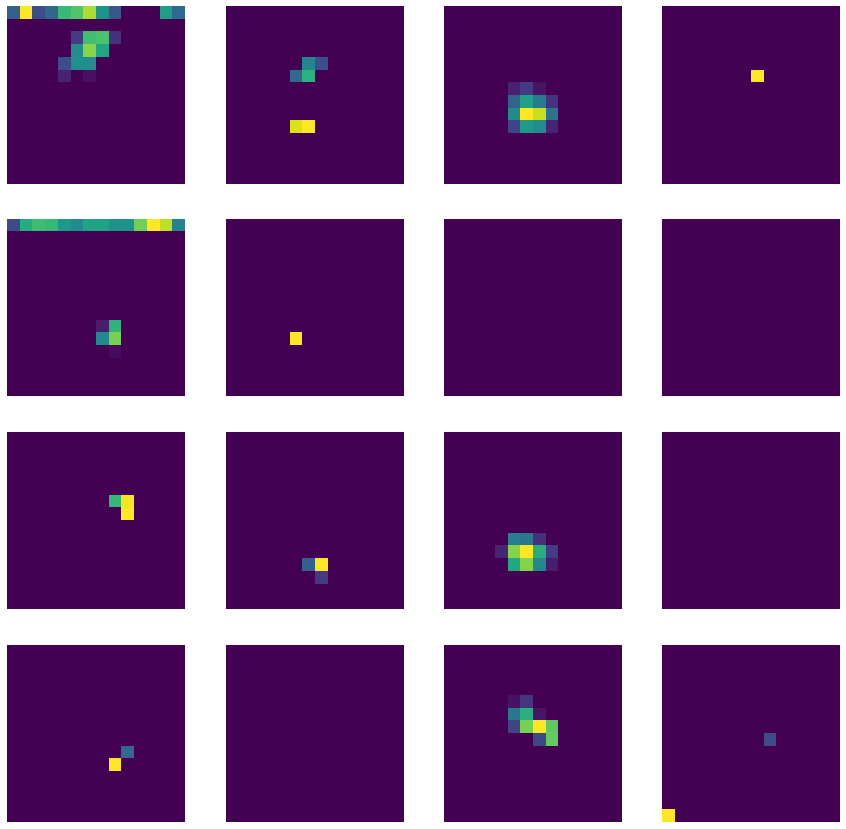

In [20]:
# Visualise some features from the extracted layer output

imgs = block5_conv4_features[0, :, :]
plt.figure(figsize=(15, 15))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(imgs[:, :, i])
    plt.axis('off')
    
plt.subplots_adjust()

***
<a id="coding_tutorial_4"></a>
## Freezing layers

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Build the model

In [4]:
# Build a small Sequential model

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

model = Sequential([
    layers.Dense(4, input_shape=(4,), activation='relu', kernel_initializer='random_uniform',
                 bias_initializer='ones'),
    layers.Dense(2, activation='relu', kernel_initializer='lecun_normal', bias_initializer='ones'),
    layers.Dense(4, activation='softmax'),
])

In [5]:
# Display the model summary

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 10        
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 12        
Total params: 42
Trainable params: 42
Non-trainable params: 0
_________________________________________________________________


#### Examine the weight matrix variation over training

In [28]:
def get_weights(model):
    return [e.weights[0].numpy() for e in model.layers]

def get_biases(model):
    return [e.bias.numpy() for e in model.layers]

def plot_delta_weights(W0_layers, W1_layers, b0_layers, b1_layers):
    plt.figure(figsize=(8,8))
    for n in range(3):
        delta_l = W1_layers[n] - W0_layers[n]
        print('Layer '+str(n)+': bias variation: ', np.linalg.norm(b1_layers[n] - b0_layers[n]))
        ax = plt.subplot(1,3,n+1)
        plt.imshow(delta_l)
        plt.title('Layer '+str(n))
        plt.axis('off')
    plt.colorbar()
    plt.suptitle('Weight matrices variation');

In [29]:
# Retrieve the weights and biases
W0_layers = get_weights(model)
b0_layers = get_biases(model)


In [30]:
# Construct a synthetic dataset

x_train = np.random.random((100, 4))
y_train = x_train

x_test = np.random.random((20, 4))
y_test = x_test

In [31]:
# Compile and fit the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

model.fit(x_train, y_train, epochs=50, verbose=False);

In [32]:
# Retrieve weights and biases

# Retrieve the weights and biases
W1_layers = get_weights(model)
b1_layers = get_biases(model)

Layer 0: bias variation:  0.0
Layer 1: bias variation:  0.031961083
Layer 2: bias variation:  0.093579255


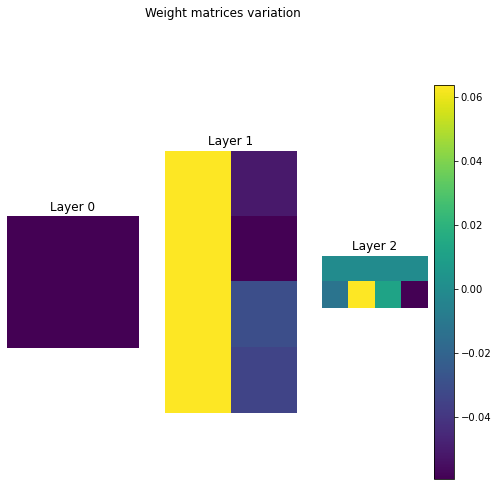

In [33]:
# Plot the variation
plot_delta_weights(W0_layers, W1_layers, b0_layers, b1_layers)


#### Freeze layers at build time

In [19]:
# Count the trainable and non trainable variables before the freezing

n_trainable_variables = len(model.trainable_variables)
n_non_trainable_variables = len(model.non_trainable_variables)

In [20]:
# Display the number of trainable and non trainable variables before the freezing

print("\n Before freezing:\n\t Number of trainable variables: ", n_trainable_variables,
                         "\n\t Number of non trainable variables: ", n_non_trainable_variables)


 Before freezing:
	 Number of trainable variables:  6 
	 Number of non trainable variables:  0


In [21]:
# Build the model

model = Sequential([
    layers.Dense(4, input_shape=(4,), activation='relu', kernel_initializer='random_uniform',
                 bias_initializer='ones', trainable=False),
    layers.Dense(2, activation='relu', kernel_initializer='lecun_normal', bias_initializer='ones'),
    layers.Dense(4, activation='softmax'),
])

In [22]:
# Count the trainable and non trainable variables after the freezing

n_trainable_variables = len(model.trainable_variables)
n_non_trainable_variables = len(model.non_trainable_variables)

In [23]:
# Display the number of trainable and non trainable variables after the freezing

print("\n After freezing:\n\t Number of trainable variables: ", n_trainable_variables,
                         "\n\t Number of non trainable variables: ", n_non_trainable_variables)


 After freezing:
	 Number of trainable variables:  4 
	 Number of non trainable variables:  2


In [24]:
# Retrieve weights and biases

W0_layers = get_weights(model)
b0_layers = get_biases(model)

In [25]:
# Compile and fit the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

model.fit(x_train, y_train, epochs=50, verbose=False);

In [26]:
# Retrieve weights and biases

W1_layers = get_weights(model)
b1_layers = get_biases(model)

Layer 0: bias variation:  0.0
Layer 1: bias variation:  0.12833667
Layer 2: bias variation:  0.2368655


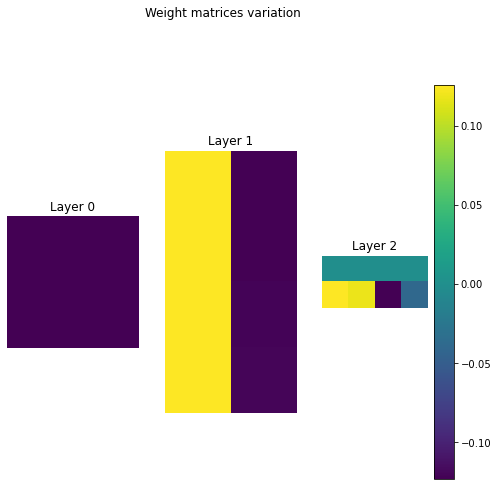

In [27]:
# Plot the variation

plot_delta_weights(W0_layers, W1_layers, b0_layers, b1_layers)

#### Freeze layers of a pre-built model

In [34]:
# Count the trainable and non trainable variables before the freezing

print("\n Before freezing:\n\t Number of trainable variables: ", len(model.trainable_variables),
                         "\n\t Number of non trainable variables: ", len(model.non_trainable_variables))


 Before freezing:
	 Number of trainable variables:  4 
	 Number of non trainable variables:  2


In [35]:
# Freeze the second layer
model.layers[1].trainable = False


In [36]:
# Count the trainable and non trainable variables after the freezing

print("\n After freezing:\n\t Number of trainable variables: ", len(model.trainable_variables),
                        "\n\t Number of non trainable variables: ", len(model.non_trainable_variables))


 After freezing:
	 Number of trainable variables:  2 
	 Number of non trainable variables:  4


In [37]:
# Compile and fit the model

model.compile(optimizer='adam',
              loss='mse',
              metrics=['acc'])

model.fit(x_train, y_train, epochs=50, verbose=False);

In [38]:
# Retrieve weights and biases
W2_layers = get_weights(model)
b2_layers = get_biases(model)


Layer 0: bias variation:  0.0
Layer 1: bias variation:  0.0
Layer 2: bias variation:  0.012085863


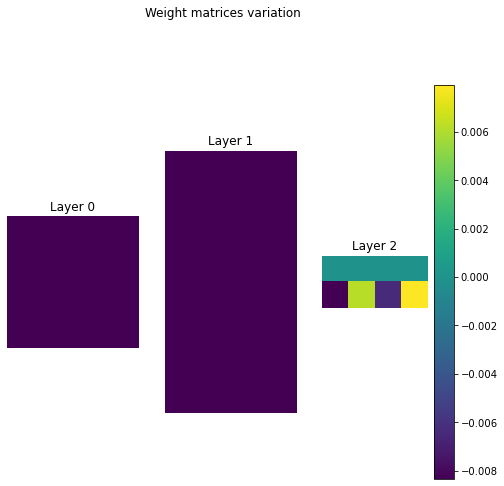

In [39]:
# Plot the variation

plot_delta_weights(W1_layers, W2_layers, b1_layers, b2_layers)